# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# TODO: Make all necessary imports.

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

2025-02-05 12:12:16.464509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-05 12:12:16.464564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-05 12:12:16.464618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.14.0
	• GPU device not found. Running on CPU


2025-02-05 12:12:19.192685: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [4]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset_flowers, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info = True, 
                                       split=['train', 'test', 'validation'])
# TODO: Create a training set, a validation set and a test set.
training_set, test_set, validation_set = dataset_flowers

Dataset oxford_flowers102 downloaded and prepared to /home/student/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Explore the Dataset

In [5]:
# TODO: Get the number of examples in each set from the dataset info.
t_examples = dataset_info.splits['train'].num_examples
print(f'There are {t_examples:,} in our training set of our Flower dataset.')

te_examples = dataset_info.splits['test'].num_examples
print(f'There are {te_examples:,} in our test set of our Flower dataset.')

v_examples = dataset_info.splits['validation'].num_examples
print(f'There are {v_examples:,} in our validation set of our Flower dataset.')
# TODO: Get the number of classes in the dataset from the dataset info.
classes = dataset_info.features['label'].num_classes

print(f'There are {classes:,} in our Flower dataset.')

There are 1,020 in our training set of our Flower dataset.
There are 6,149 in our test set of our Flower dataset.
There are 1,020 in our validation set of our Flower dataset.
There are 102 in our Flower dataset.


In [6]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    print(f'Image shape : {image.shape}, and its corresponding label is : {label}')

Image shape : (500, 667, 3), and its corresponding label is : 72
Image shape : (500, 666, 3), and its corresponding label is : 84
Image shape : (670, 500, 3), and its corresponding label is : 70


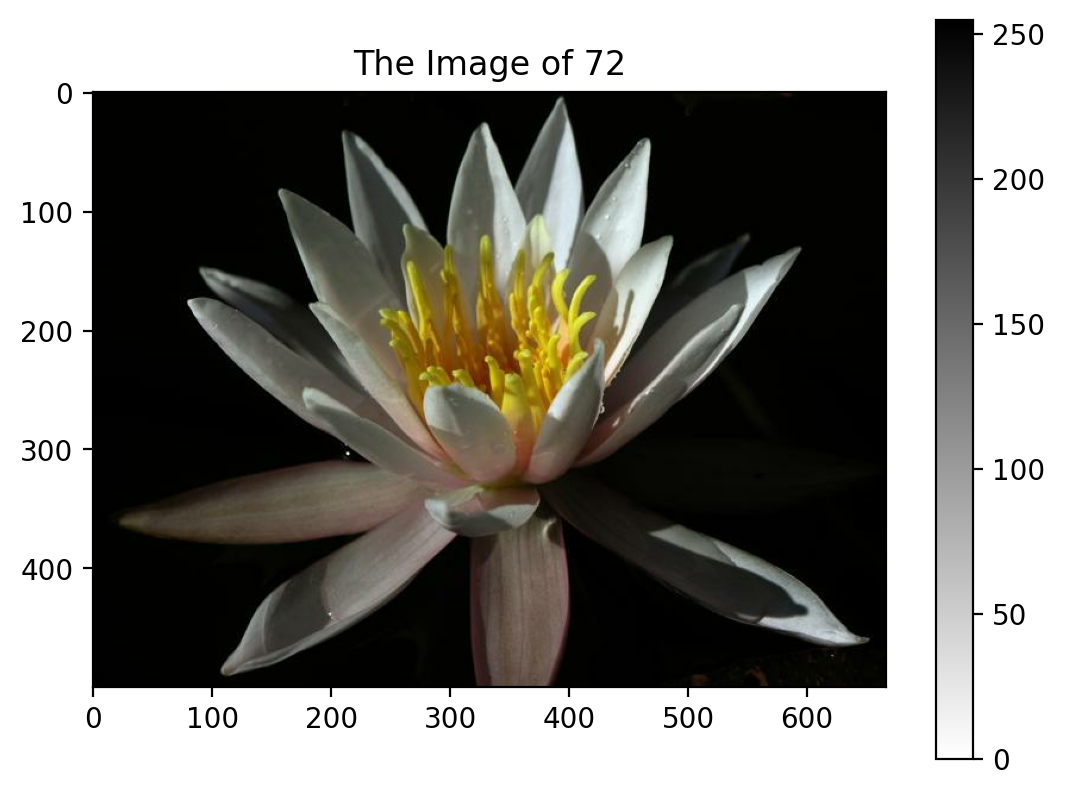

In [7]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 

for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.title(f'The Image of {label}')
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [8]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [9]:
print(class_names)

{'0': 'pink primrose', '1': 'hard-leaved pocket orchid', '2': 'canterbury bells', '3': 'sweet pea', '4': 'english marigold', '5': 'tiger lily', '6': 'moon orchid', '7': 'bird of paradise', '8': 'monkshood', '9': 'globe thistle', '10': 'snapdragon', '11': "colt's foot", '12': 'king protea', '13': 'spear thistle', '14': 'yellow iris', '15': 'globe-flower', '16': 'purple coneflower', '17': 'peruvian lily', '18': 'balloon flower', '19': 'giant white arum lily', '20': 'fire lily', '21': 'pincushion flower', '22': 'fritillary', '23': 'red ginger', '24': 'grape hyacinth', '25': 'corn poppy', '26': 'prince of wales feathers', '27': 'stemless gentian', '28': 'artichoke', '29': 'sweet william', '30': 'carnation', '31': 'garden phlox', '32': 'love in the mist', '33': 'mexican aster', '34': 'alpine sea holly', '35': 'ruby-lipped cattleya', '36': 'cape flower', '37': 'great masterwort', '38': 'siam tulip', '39': 'lenten rose', '40': 'barbeton daisy', '41': 'daffodil', '42': 'sword lily', '43': 'poi

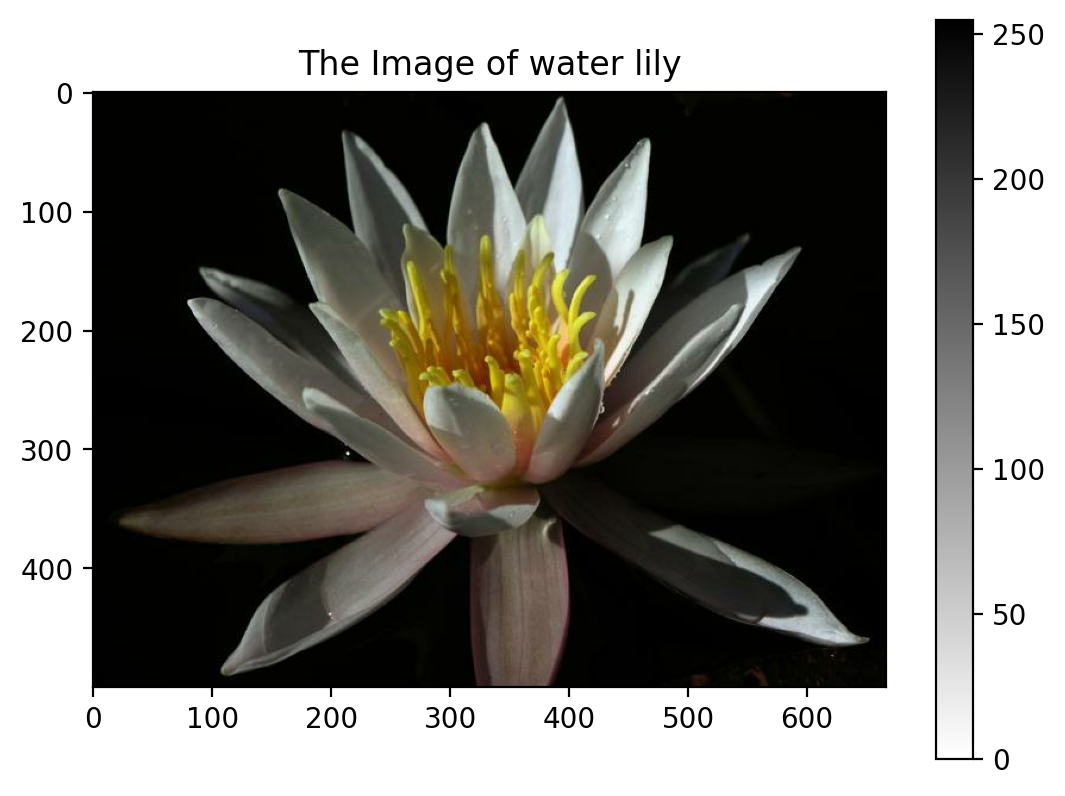

In [10]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    name_class = class_names[f'{label}']

plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.title(f'The Image of {name_class}')
plt.show()


## Create Pipeline

In [11]:
# TODO: Create a pipeline for each set.
batches = 64

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image /= 255
    return image, label

training_batches = (training_set.shuffle(t_examples//4)
.map(normalize).batch(batches).prefetch(1)
                   )

testing_batches = test_set.map(normalize).batch(batches).prefetch(1)

validation_batches = validation_set.map(normalize).batch(batches).prefetch(1)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [12]:
# Load the pre-trained model
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5"
f_extractor = hub.KerasLayer(mobilenet_url, input_shape=(224, 224, 3), trainable=False)  


In [13]:
# let's check the hub version
print(hub.__version__)

0.16.1


In [14]:
# TODO: Build and train your network.
model = tf.keras.Sequential([
    f_extractor,
    tf.keras.layers.Dense(classes, activation = 'softmax')
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2731616   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2862278 (10.92 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2731616 (10.42 MB)
_________________________________________________________________


In [15]:
# Getting the model ready for training

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(training_batches,
                    epochs=30,
                    validation_data=validation_batches)

Epoch 1/30
16/16 [==============================] - 104s 6s/step - loss: 4.3986 - accuracy: 0.0882 - val_loss: 3.6677 - val_accuracy: 0.3304
Epoch 2/30
16/16 [==============================] - 96s 6s/step - loss: 2.9719 - accuracy: 0.6206 - val_loss: 2.7350 - val_accuracy: 0.6176
Epoch 3/30
16/16 [==============================] - 94s 6s/step - loss: 2.0068 - accuracy: 0.8490 - val_loss: 2.0815 - val_accuracy: 0.7412
Epoch 4/30
16/16 [==============================] - 99s 6s/step - loss: 1.3636 - accuracy: 0.9294 - val_loss: 1.6581 - val_accuracy: 0.7941
Epoch 5/30
16/16 [==============================] - 97s 6s/step - loss: 0.9516 - accuracy: 0.9637 - val_loss: 1.3945 - val_accuracy: 0.8216
Epoch 6/30
16/16 [==============================] - 95s 6s/step - loss: 0.7043 - accuracy: 0.9775 - val_loss: 1.2210 - val_accuracy: 0.8324
Epoch 7/30
16/16 [==============================] - 98s 6s/step - loss: 0.5397 - accuracy: 0.9873 - val_loss: 1.1012 - val_accuracy: 0.8441
Epoch 8/30
16/16 [=

Let's use the `history.history` dictionary to plot our model's loss and accuracy values obtained during training.

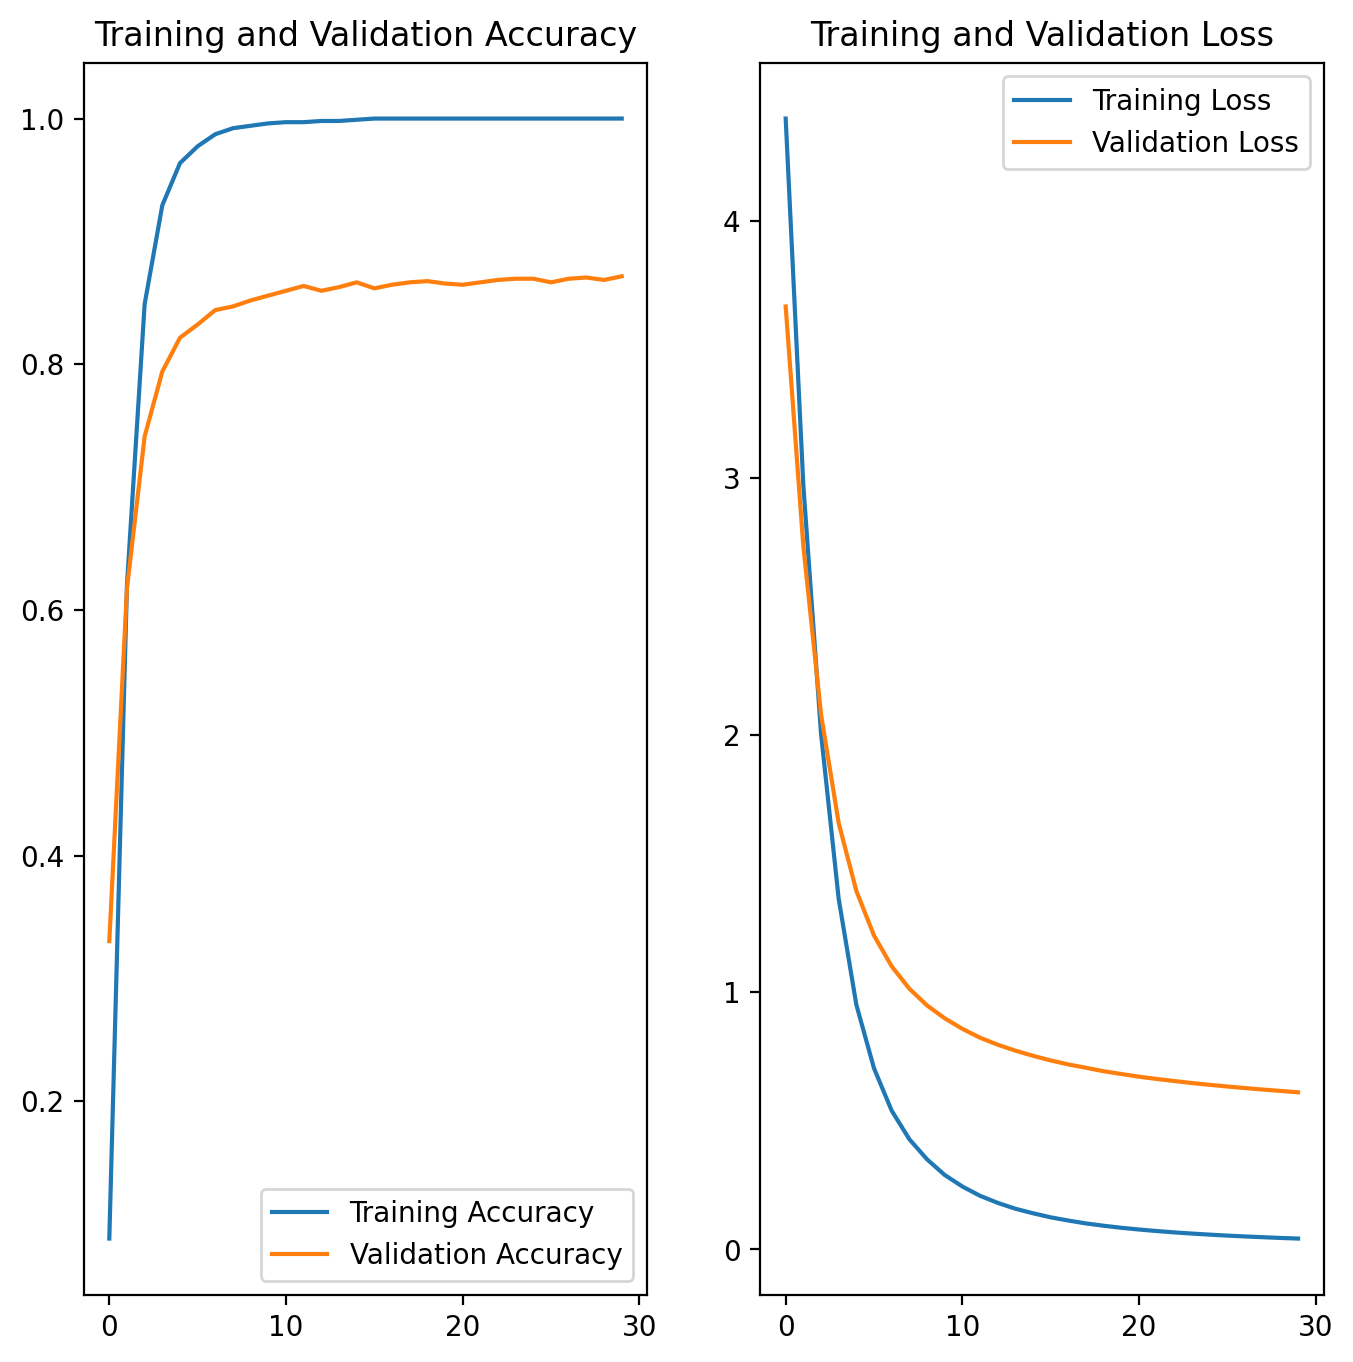

In [18]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [19]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(testing_batches)

print(f'\nLoss on the TEST Set: {loss:,.3f}')
print(f'Accuracy on the TEST Set: {accuracy:.3%}')


97/97 [==============================] - 288s 3s/step - loss: 0.6886 - accuracy: 0.8423

Loss on the TEST Set: 0.689
Accuracy on the TEST Set: 84.225%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [20]:
# TODO: Save your trained model as a Keras model.
import time
t = time.time()

saved_h5_model_path = f'./{int(t)}.h5'

model.save(saved_h5_model_path)


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load the Keras Model

Load the Keras model you saved above.

In [21]:
# TODO: Load the Keras model
# Since the model uses TensorFlow Hub layer, the KerasLayer needs to be specified in custom_objects.

load_model = tf.keras.models.load_model(saved_h5_model_path, custom_objects={'KerasLayer':hub.KerasLayer})
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2731616   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2862278 (10.92 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2731616 (10.42 MB)
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [22]:
# TODO: Create the process_image function

def process_image(image):
    """
    Pre-process an image for model prediction.
    
    Args:
    - image (numpy array): Input image.
    
    Returns:
    - numpy array: Preprocessed image with shape (224, 224, 3).
    """
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image /= 255.0
    return image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

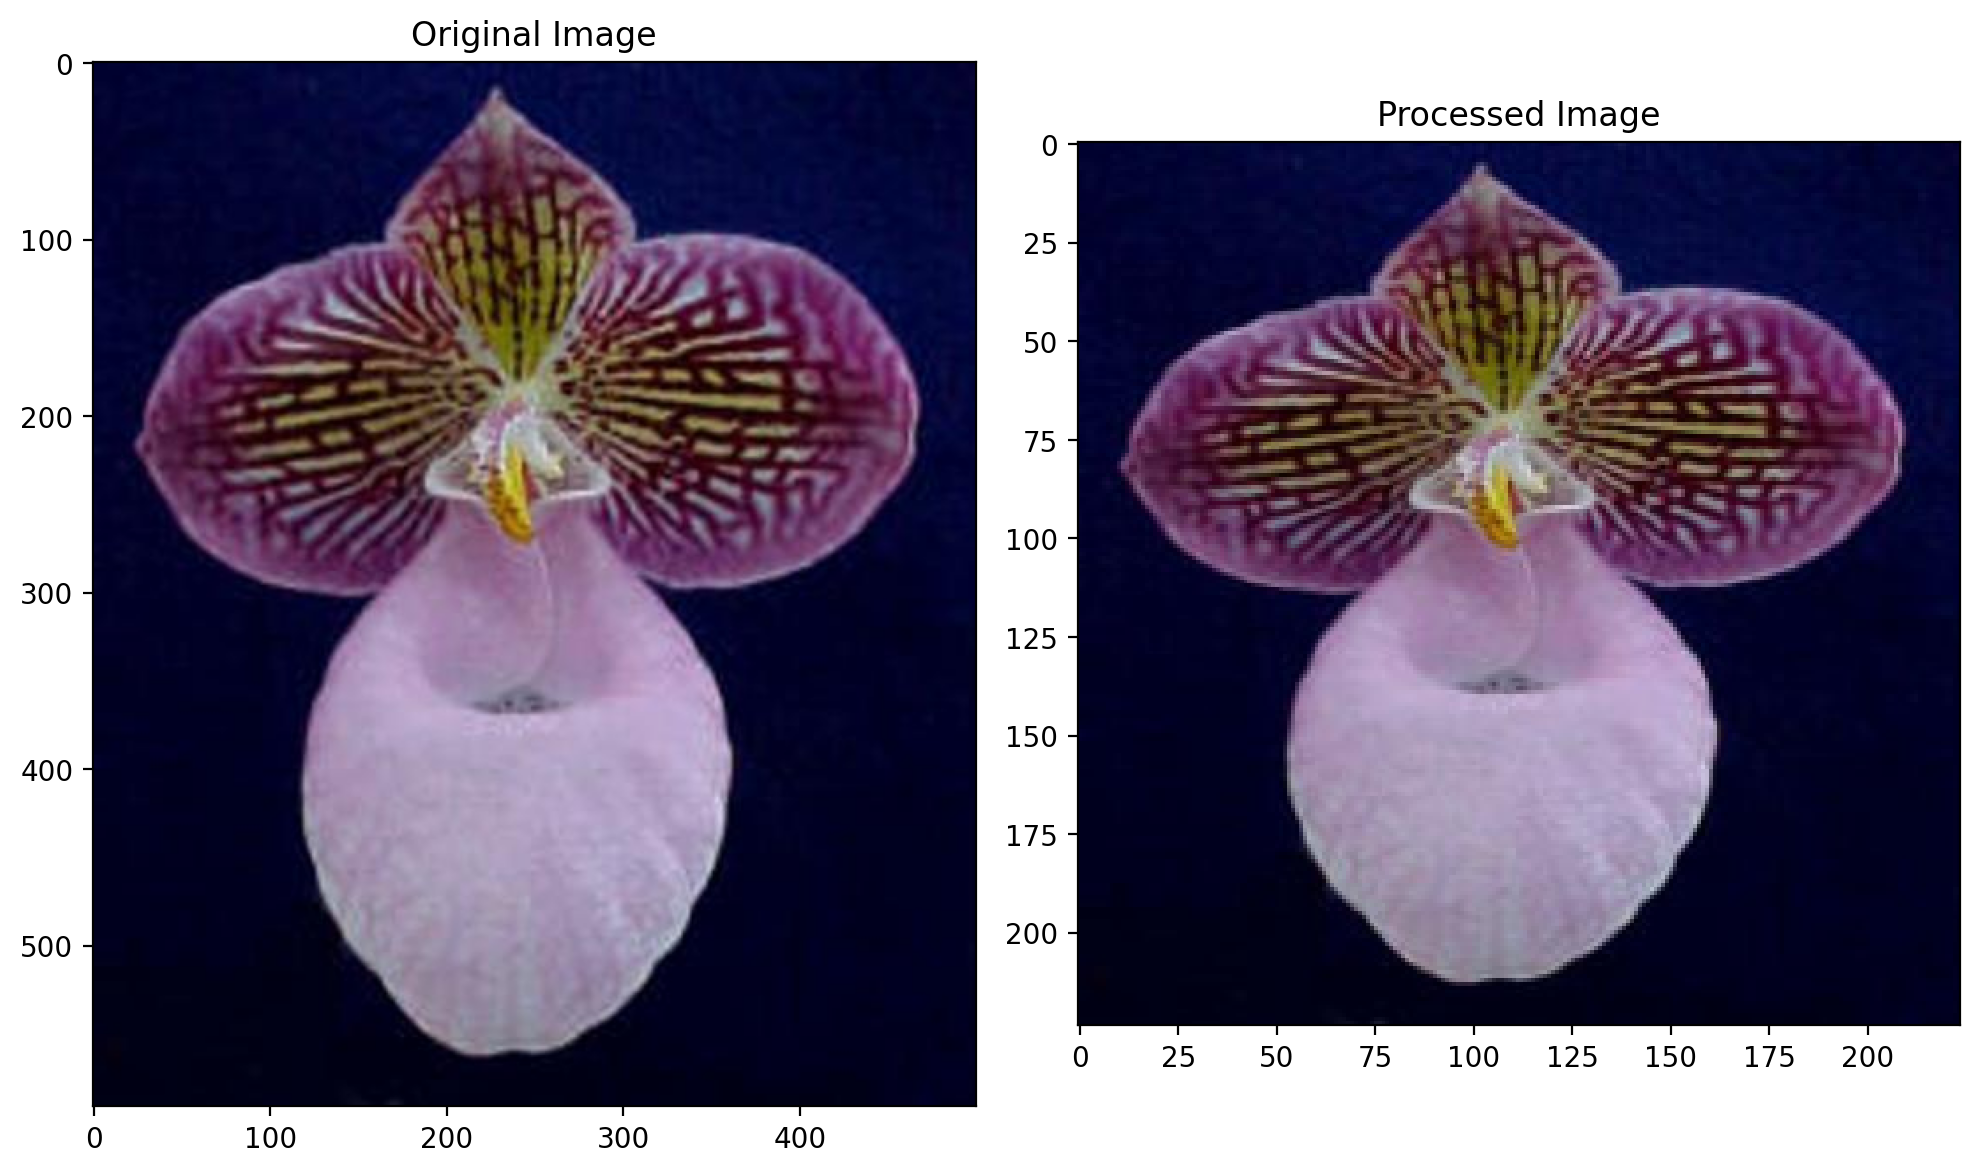

In [23]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [42]:
# TODO: Create the predict function
def predict(image_p, model, top_k):
    """
    Perform inference on an image and return the top K predictions.
    
    Args:
    - image_path (str): Path to the input image.
    - model (tf.keras.Model): Trained TensorFlow model.
    - top_k (int): Number of top predictions to return.
    
    Returns:
    - probs (list): Top K probabilities.
    - classes (list): Corresponding class labels.
    """
    
    # First let's load the image using PIL
    im = Image.open(image_p)
    
    # Let's then convert it to numpy array
    im = np.asarray(im)
    
    # using our function process_image we need to pre-process the image
    im = process_image(im)
    
    # Since the model expect batches we need to add batch dimention 
    im = np.expand_dims(im, axis = 0)
    
    # Let's now let the model perform predictions
    prds = model.predict(im)
    
    # extract the top k prediction using argsort function 
    prbs = -np.partition(-prds[0], top_k)[:top_k]
    classes = np.argpartition(-prds[0], top_k)[:top_k]
    
    return prbs, classes
    
    


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

['cautleya_spicata.jpg', 'orange_dahlia.jpg', 'wild_pansy.jpg', 'hard-leaved_pocket_orchid.jpg']
1/1 [==============================] - 0s 101ms/step


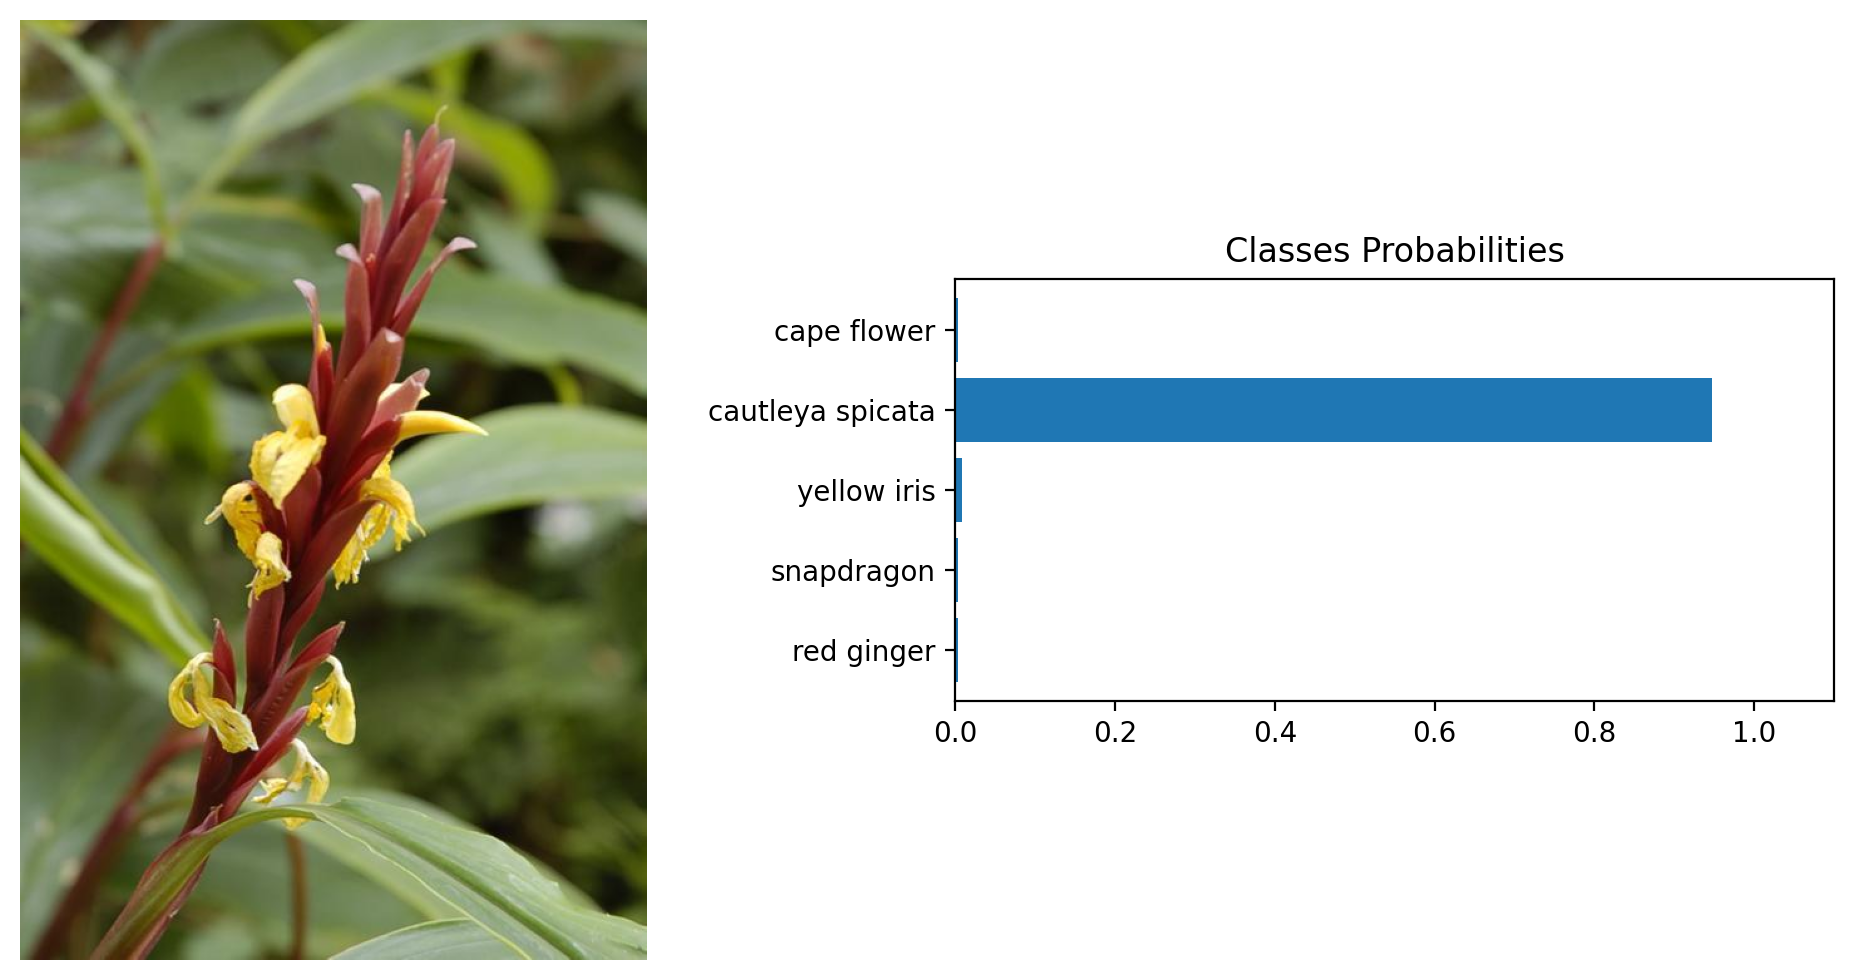

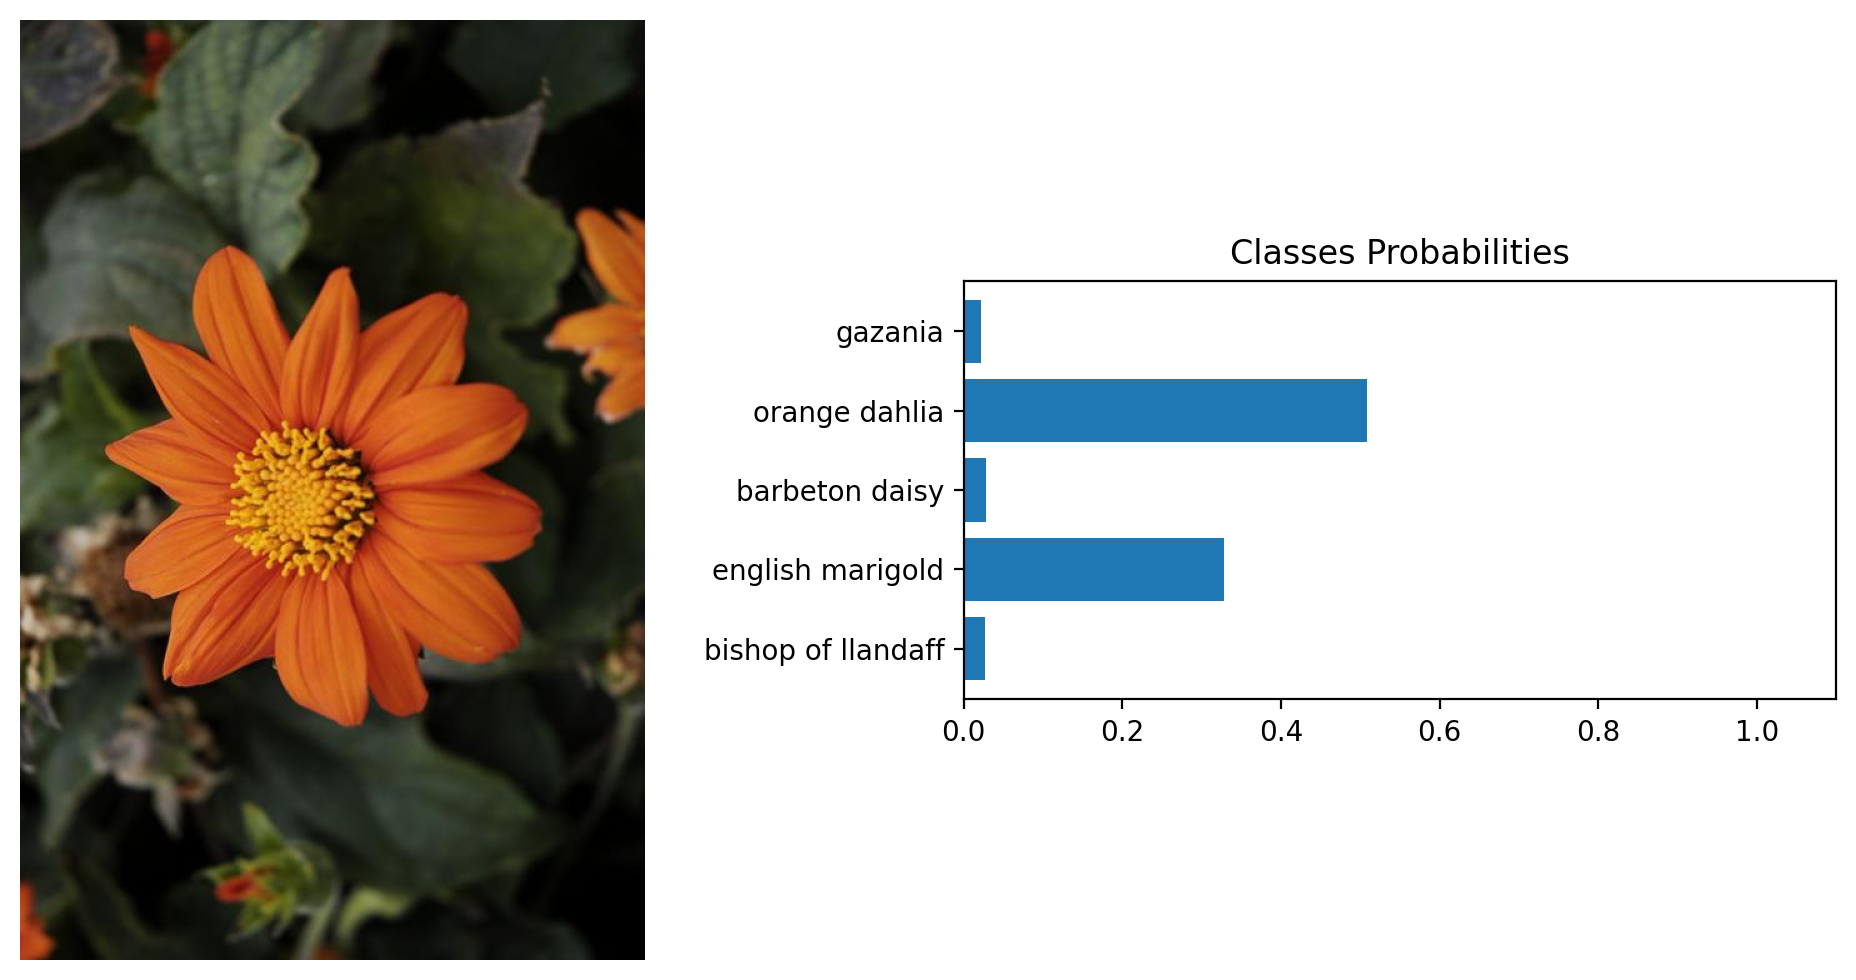

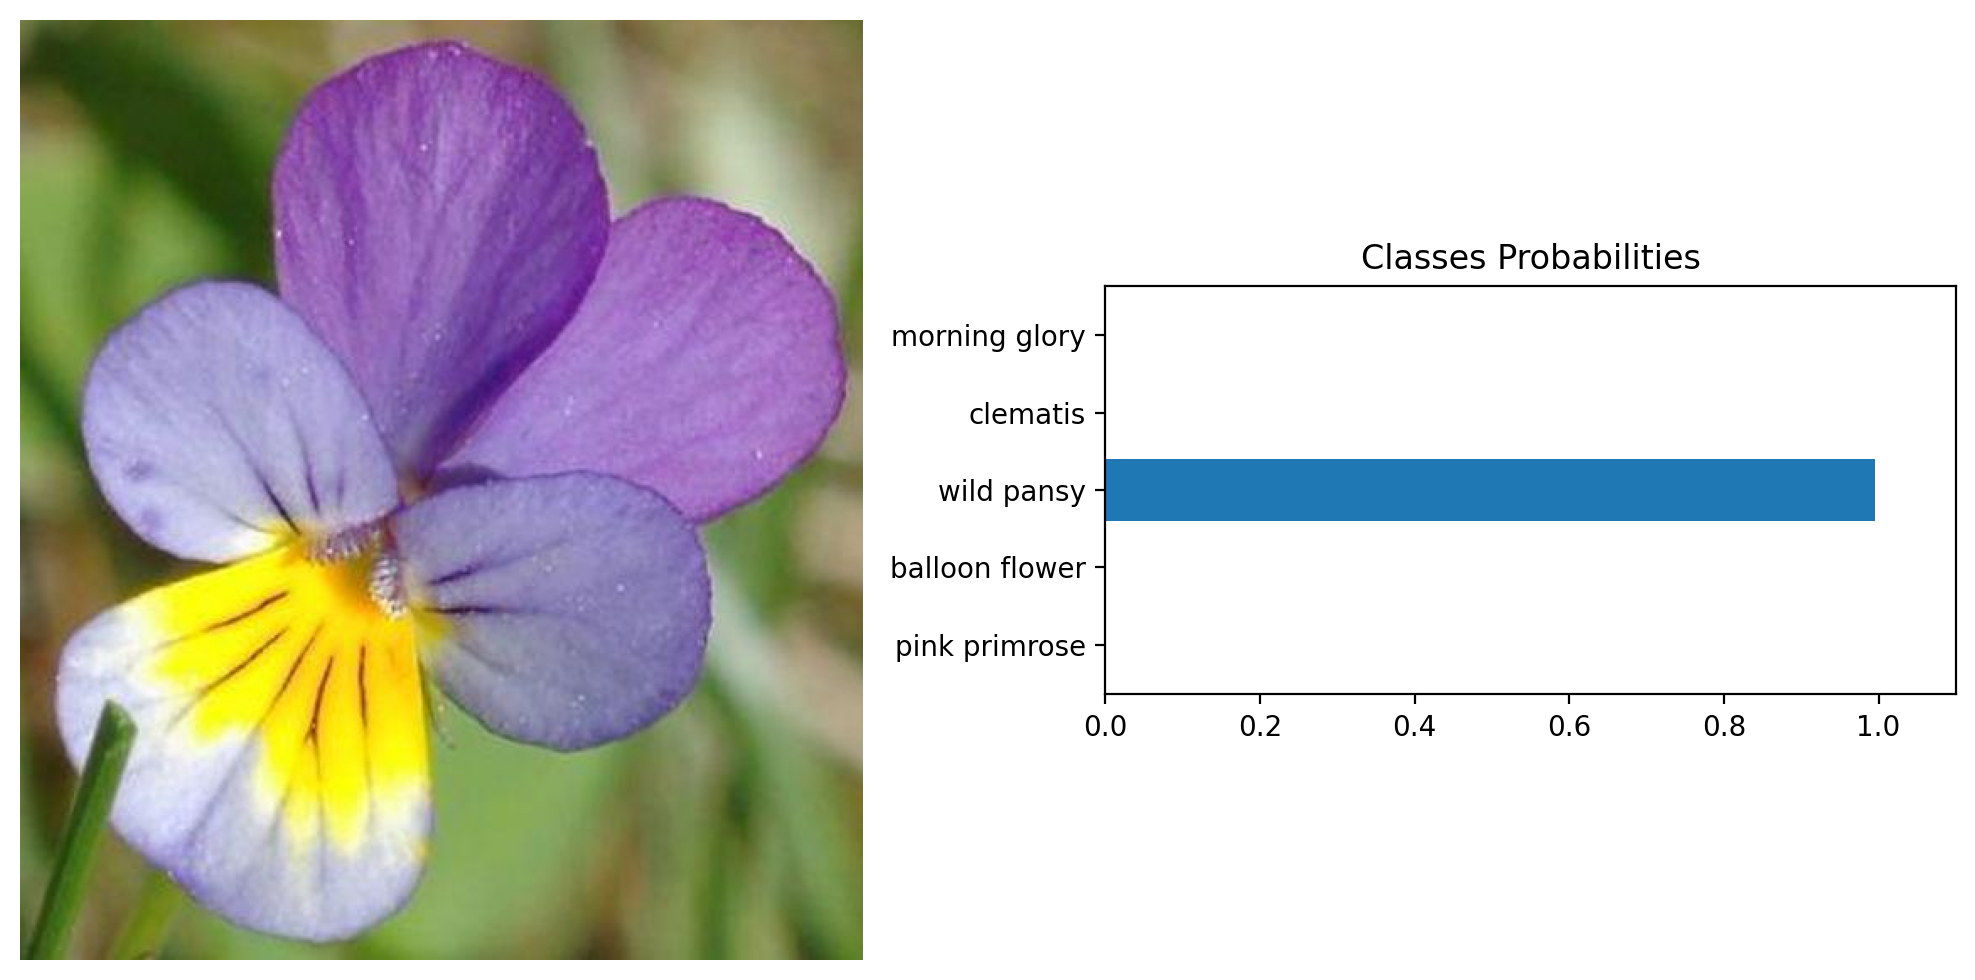

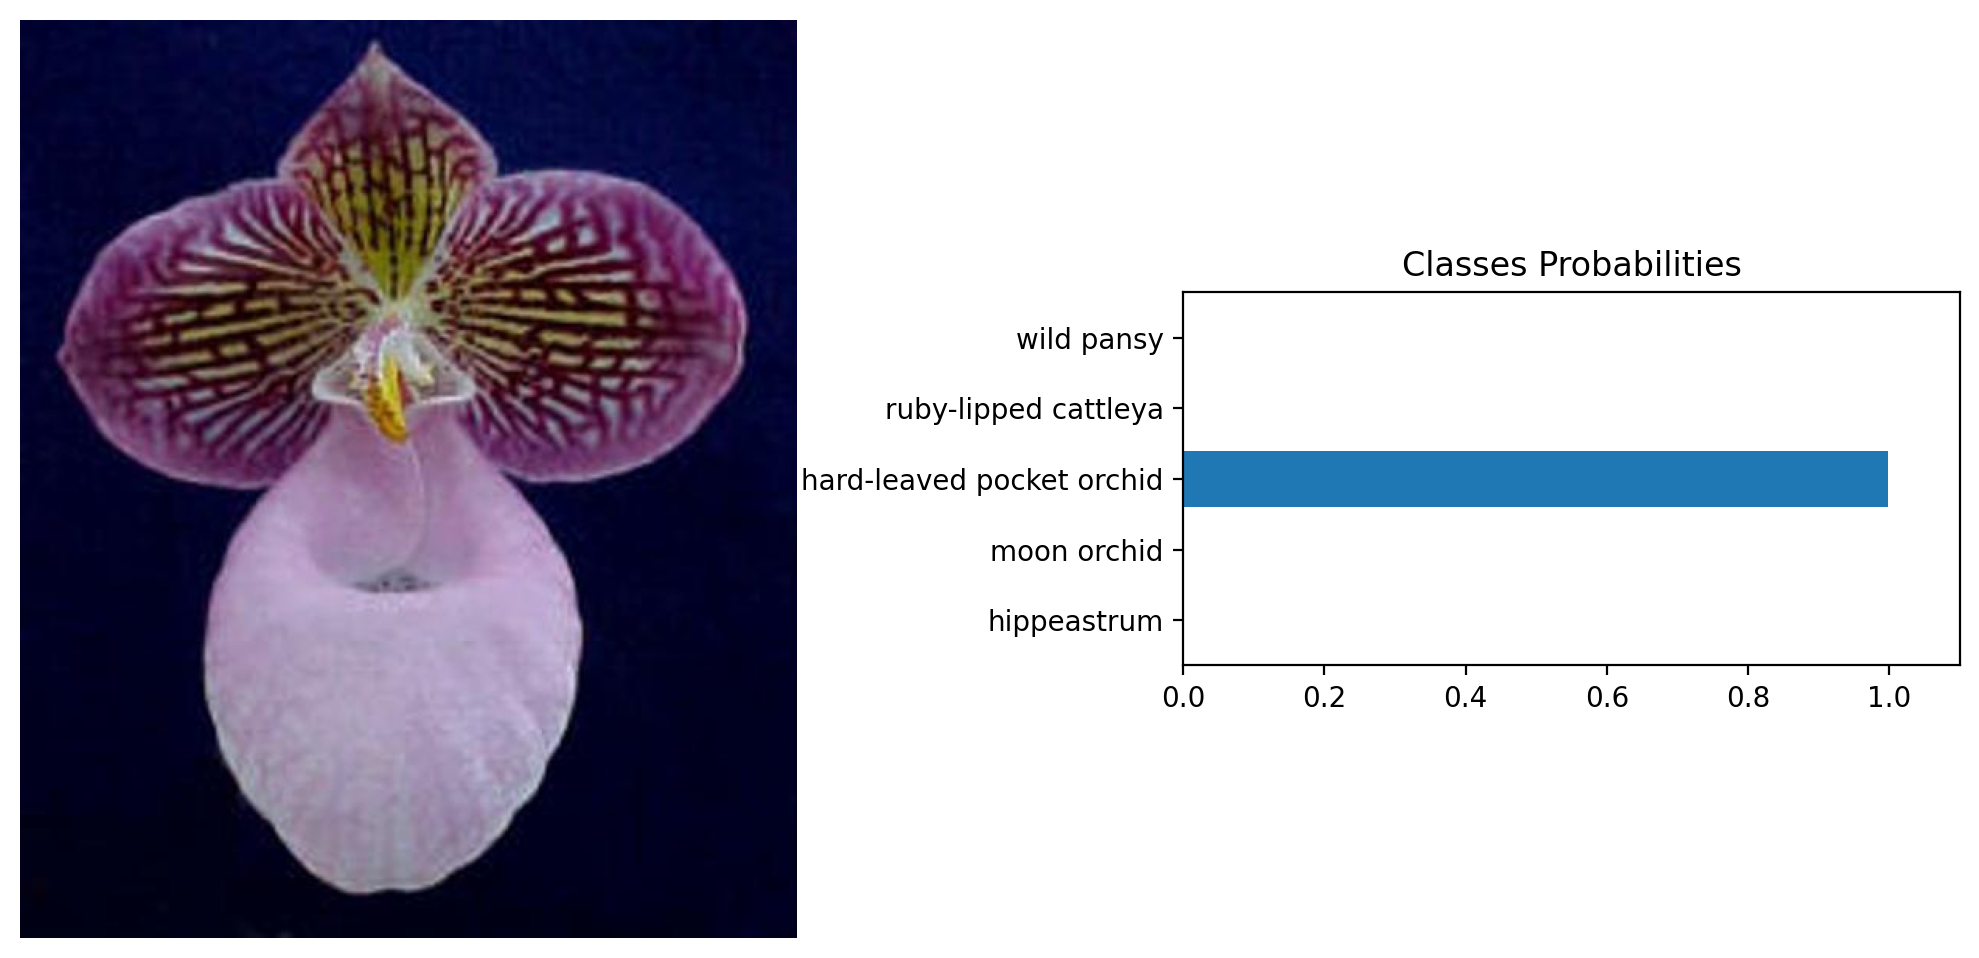

In [43]:
# TODO: Plot the input image along with the top 5 classes
import os
test_ims = []
for dir in os.listdir('./test_images'):
    test_ims.append(dir)
print(test_ims)

for im in test_ims:
    im_p = './test_images/' + im
    im = np.asarray(Image.open(im_p)).squeeze()
    probs, classes = predict(im_p,model, 5)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(im, cmap=plt.cm.binary)
    ax1.axis('off')
    ax2.barh(np.arange(5), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ks = [str(i) for i in list(classes)]
    f_names = [class_names.get(m) for m in ks]
    ax2.set_yticklabels(f_names)
    ax2.set_title('Classes Probabilities')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    
